Using `maf_proto` branch of `rubin_sim`

In [1]:
import matplotlib.pylab as plt 
%matplotlib inline
import numpy as np
import rubin_sim.maf_proto as maf
import pandas as pd
import sqlite3
import healpy as hp
import copy
import datetime

from os.path import basename

In [2]:
# Read in the current baseline
db_file = "baseline_v5.1.0_10yrs.db"
run_name = basename(db_file).replace('.db', '')
con = sqlite3.connect(db_file)
df = pd.read_sql('select * from observations;', con)
con.close()
# Convert to a numpy array
visits_array = df.to_records(index=False)

In [3]:
v = " (" + run_name.replace('baseline_', '').split('_')[0] + ")"

In [4]:
data_selections = {"DDFs": ["DD:" in note and "RGES" not in note for note in visits_array["scheduler_note"]],
                  "Pair 33": ["pair_33" in note for note in visits_array["scheduler_note"]],
                  "Templates": ["template" in note for note in visits_array["scheduler_note"]],
                  "Roman": ["RGES" in note for note in visits_array["scheduler_note"]],
                   "Pair 15": ["pair_15" in note for note in visits_array["scheduler_note"]],
                  "Greedy": ["greedy" in note for note in visits_array["scheduler_note"]],
                  "ToO": ["ToO" in note for note in visits_array["scheduler_note"]],
                  "Earth Interior": ["twilight" in note for note in visits_array["scheduler_note"]],
                  "Initial Long": ["blob_long" in note for note in visits_array["scheduler_note"]],
                  "Final Long": ["long" in note for note in visits_array["scheduler_note"]],
                  "all": np.arange(visits_array.size)}


In [5]:
fig_saver = maf.FigSaver(close_figs=False, results_file="tiers/maf_results.db", png_dpi=None)

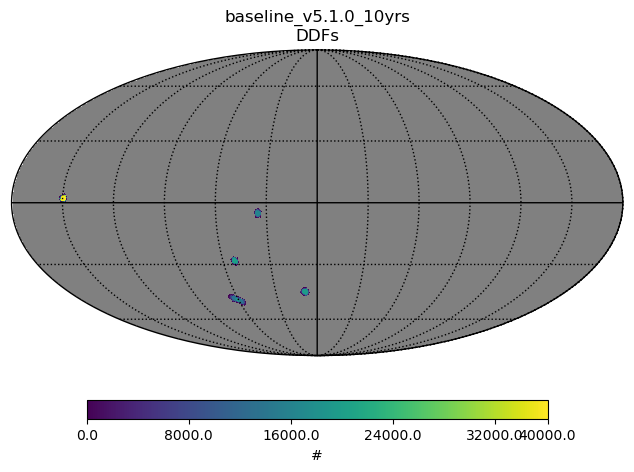

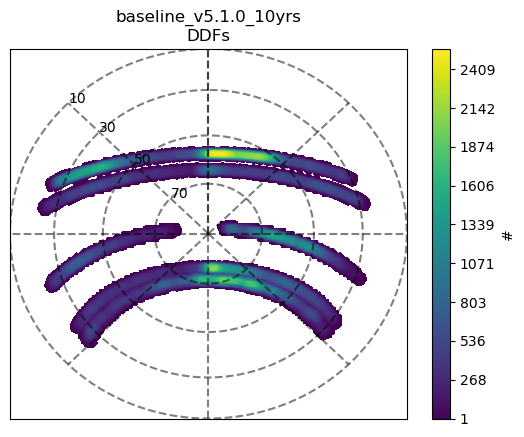

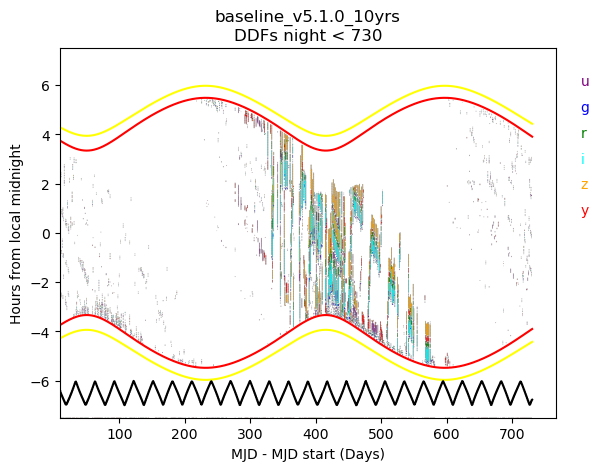

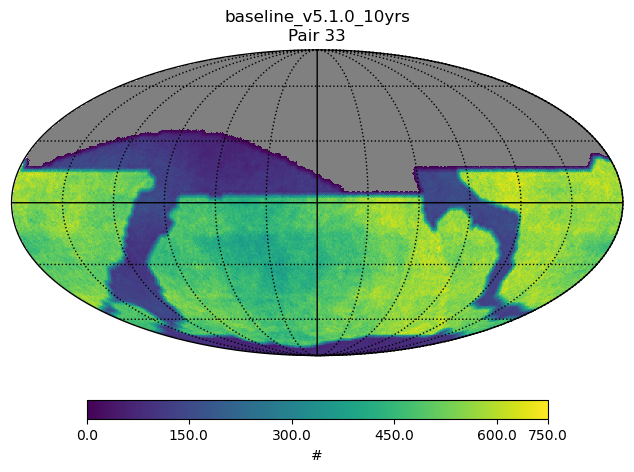

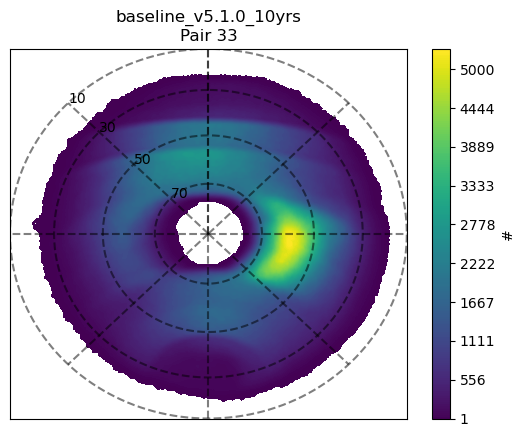

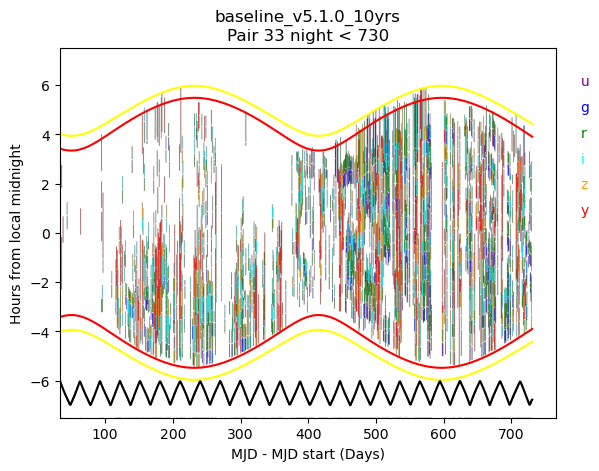

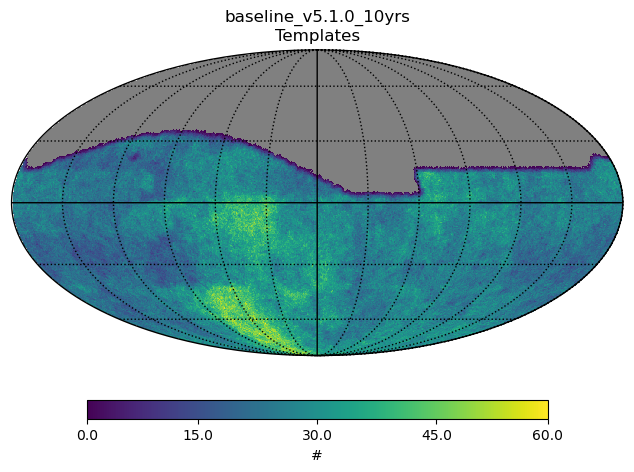

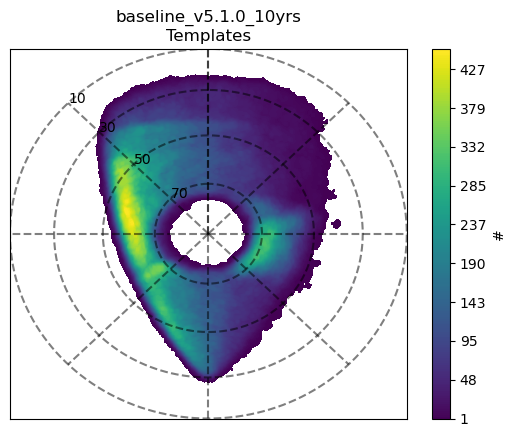

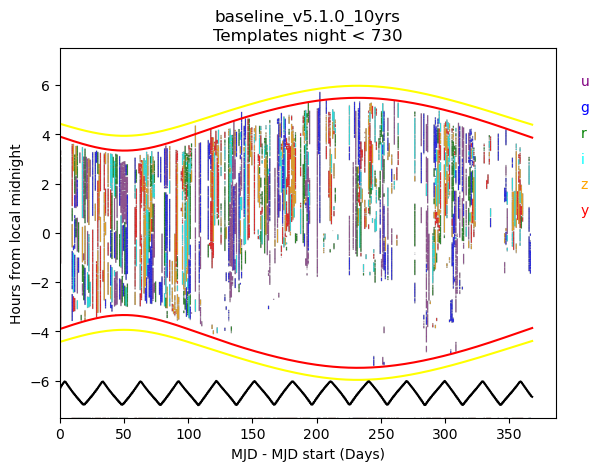

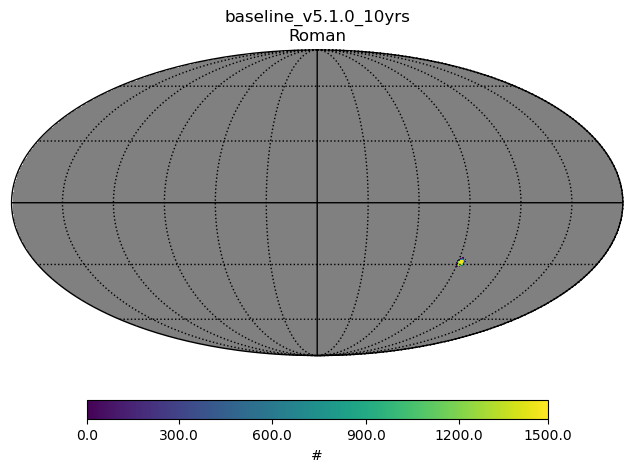

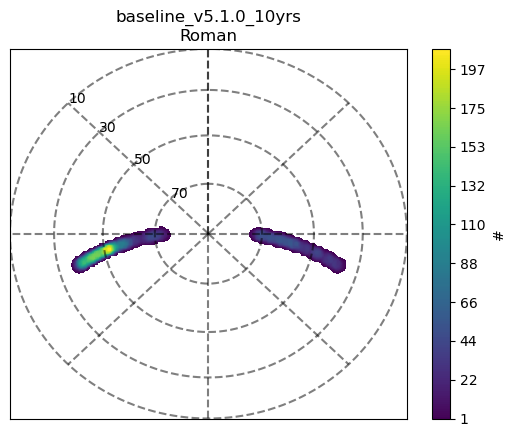

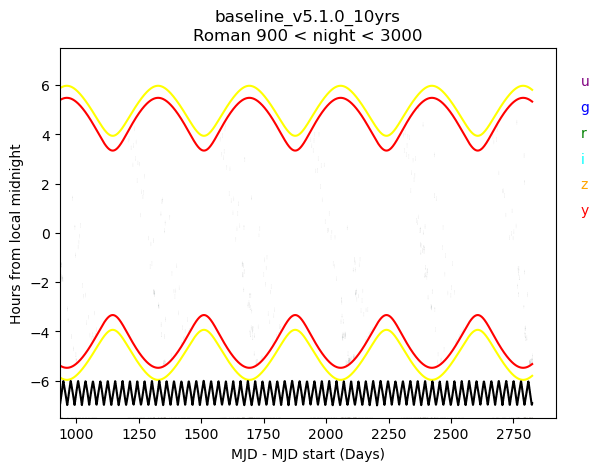

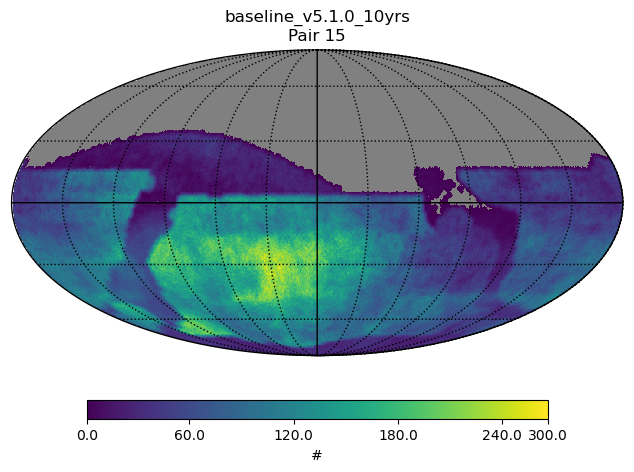

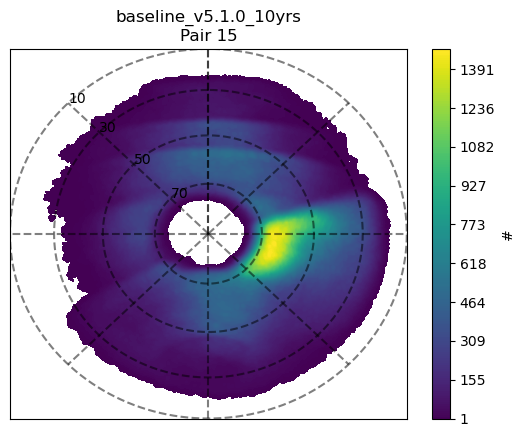

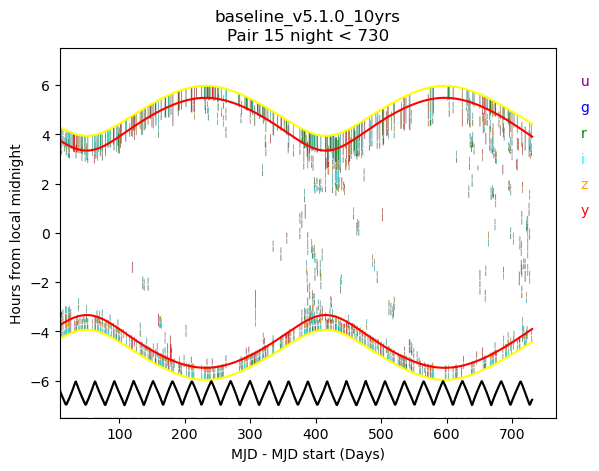

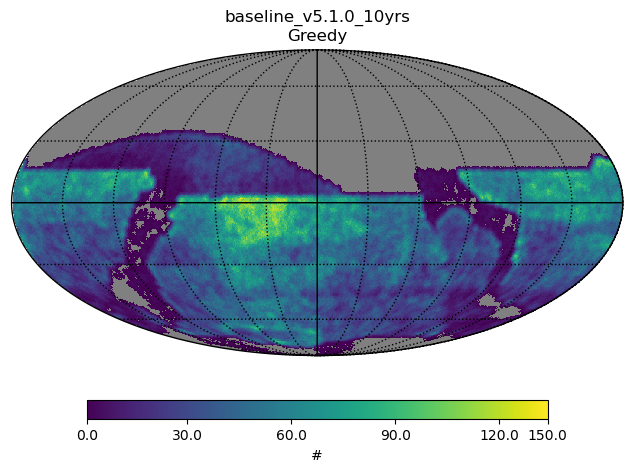

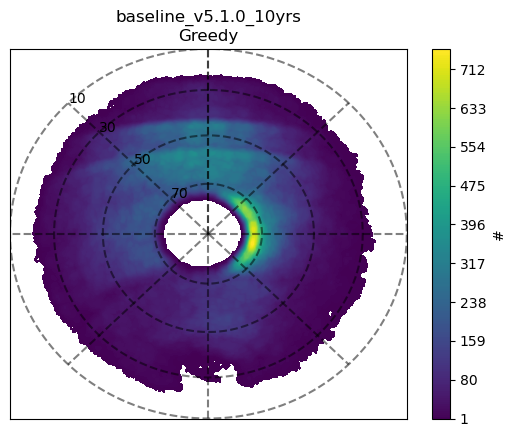

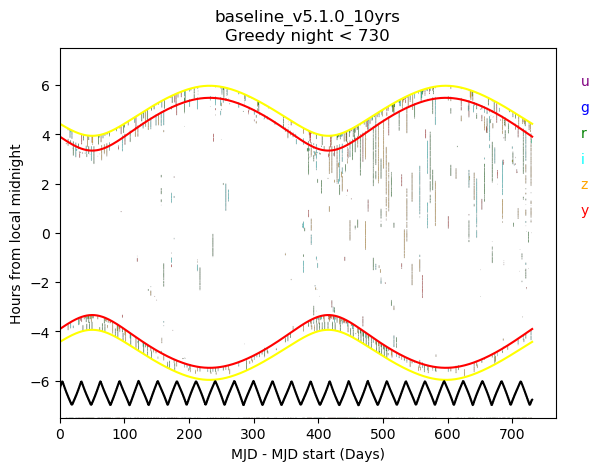

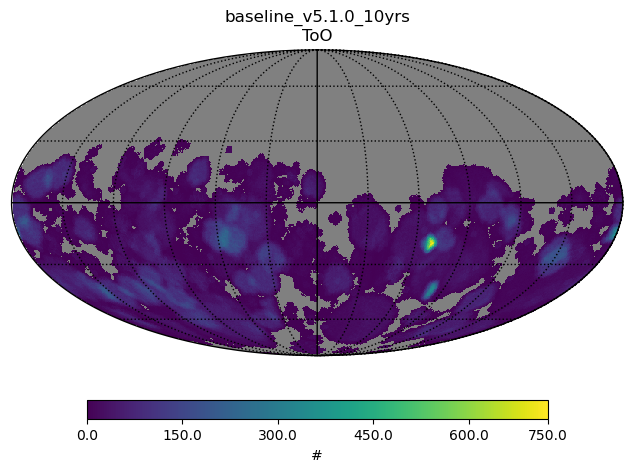

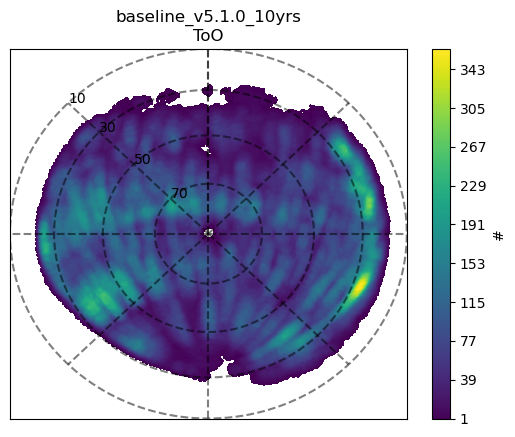

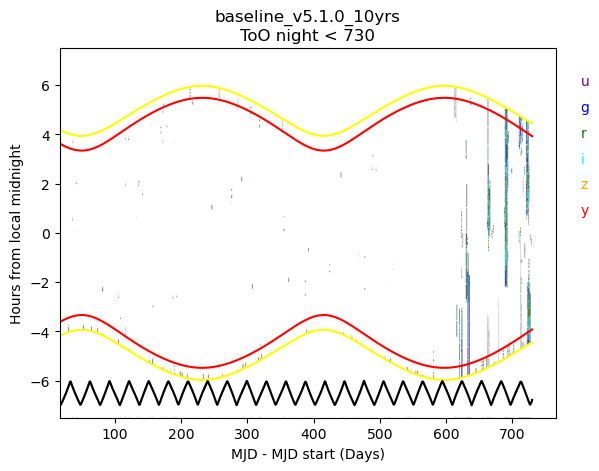

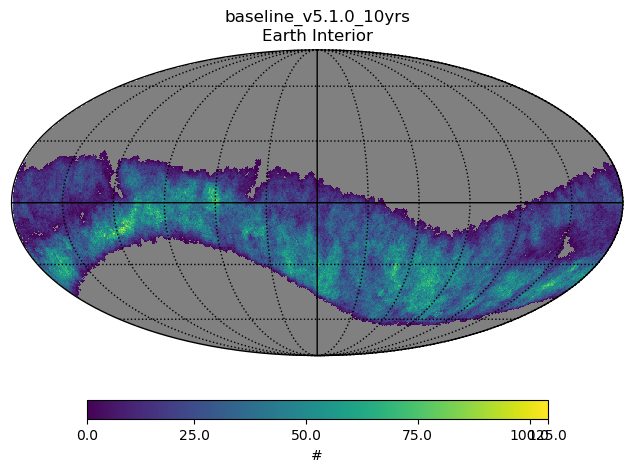

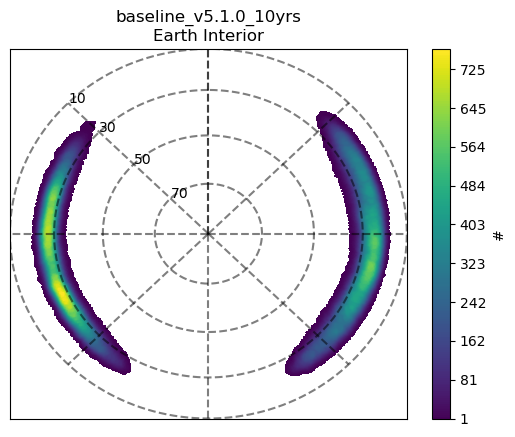

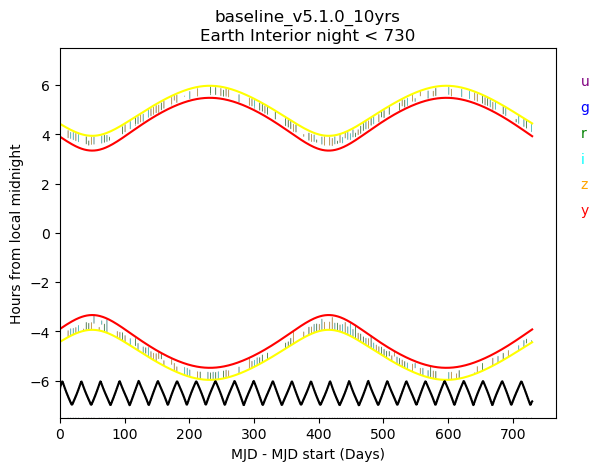

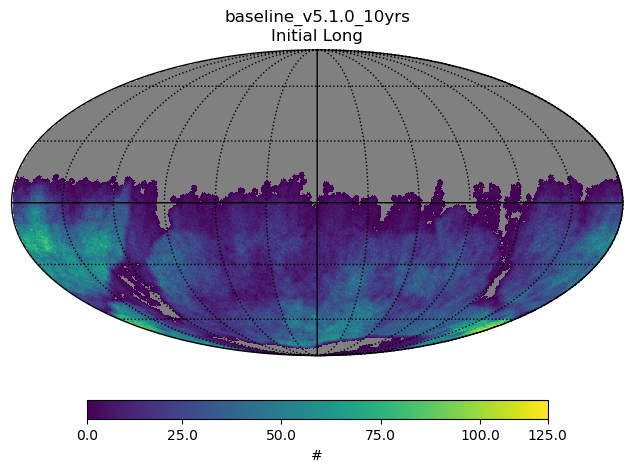

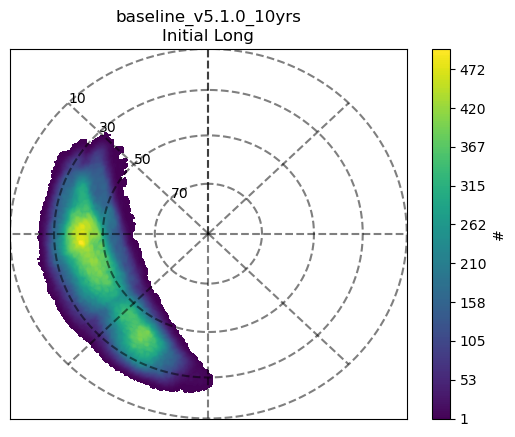

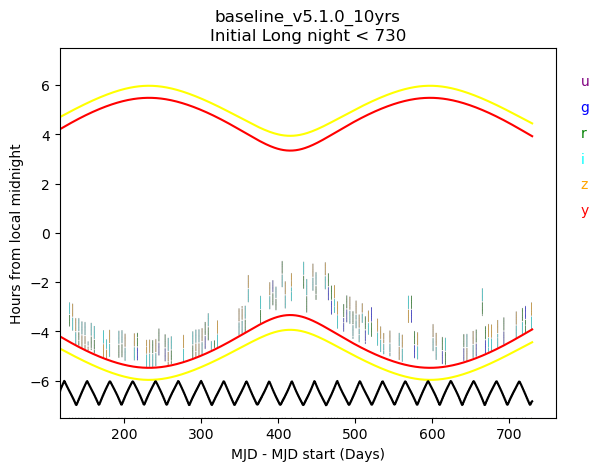

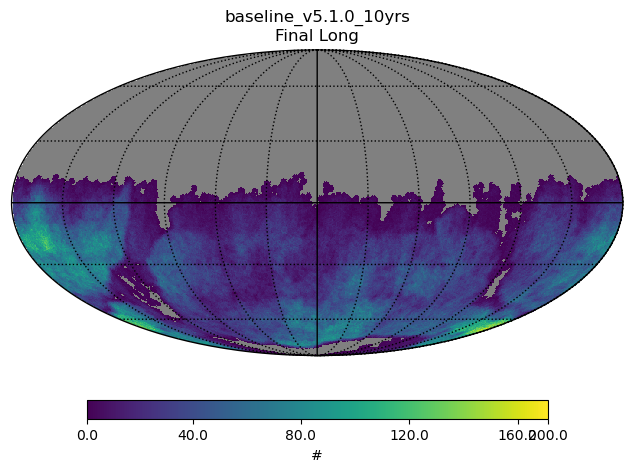

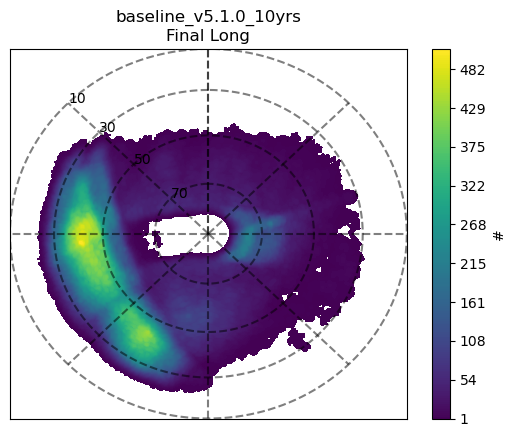

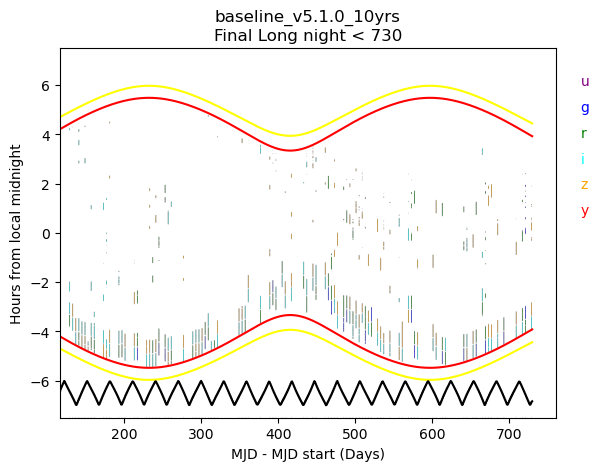

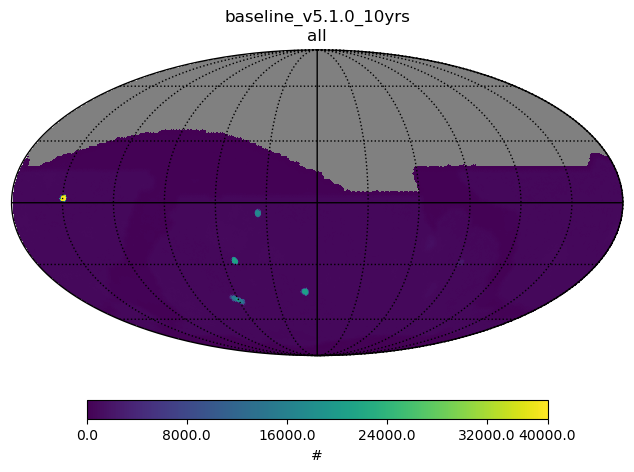

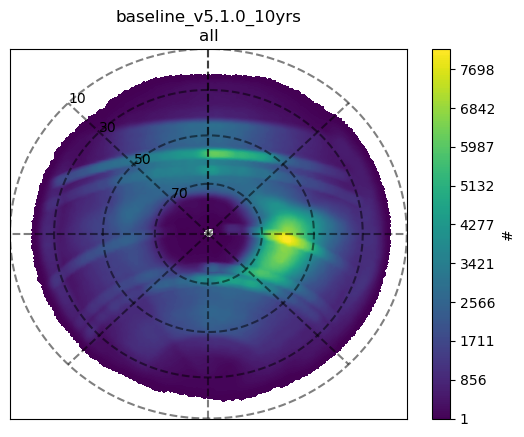

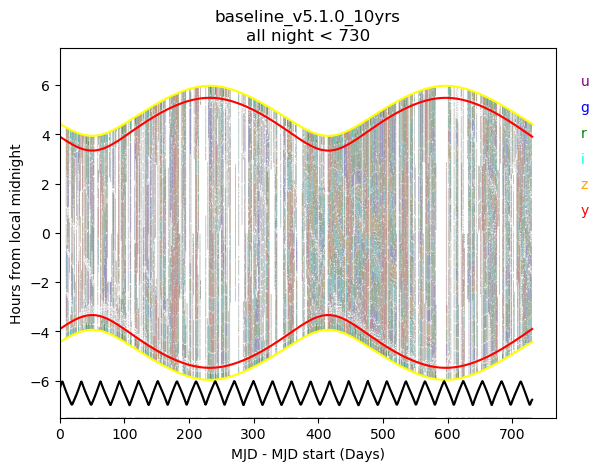

In [6]:


for key in data_selections:
    info = {"run_name": run_name}
    info["observations_subset"] = key
    sl = maf.Slicer()
    metric = maf.CountMetric()
    hp_array, info = sl(visits_array[data_selections[key]], metric, info=info)

    pm = maf.PlotMoll(info=info)
    fig = pm(hp_array)
    fig_saver(fig, info)

    sl = maf.Slicer(lon_col="azimuth", lat_col="altitude", nside=64)
    hp_array, info = sl(visits_array[data_selections[key]], metric, info=info)

    pl = maf.PlotLambert(info=info)
    fig = pl(hp_array)
    fig_saver(fig, info)

    if key == "Roman":
        indx = np.where((data_selections[key]) & (visits_array["night"] > 900) & (visits_array["night"] < 3000))[0]
        info = {"run_name": run_name, "observations_subset": key + " 900 < night < 3000", "metric: name": "Hourglass"}
    else:

        indx = np.where((data_selections[key]) & (visits_array["night"] < 730))[0]
        info = {"run_name": run_name, "observations_subset": key + " night < 730", "metric: name": "Hourglass"}
    hr = maf.PlotHourglassImage(info=info)
    fig = hr(visits_array[indx])
    fig_saver(fig, info=info)